In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd

df = dd.read_csv("../VoxelsDataset/2ellipsoids/*").compute().set_index('Unnamed: 0')

In [2]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :400]
Y = df.iloc[:, 400:]

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.7, random_state = 42)

In [3]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_val = ss.transform(x_val)
x_test = ss.transform(x_test)


In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD, Adam


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=50, verbose=1,)
early_stop = EarlyStopping(monitor='val_loss', patience=61, verbose=1, restore_best_weights=True)
opt = Adam()

model = Sequential()
model.add(Dense(1000, input_dim=400, kernel_initializer='normal', activation='relu'))
model.add(Dense(1331, kernel_initializer='normal', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'], )
model.summary()

Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              401000    
_________________________________________________________________
dense_2 (Dense)              (None, 1331)              1332331   
Total params: 1,733,331
Trainable params: 1,733,331
Non-trainable params: 0
_________________________________________________________________


In [5]:
history = model.fit(x=x_train, y=y_train, validation_data = (x_val, y_val), epochs=1000, verbose=1, callbacks=[early_stop, reduce_lr])

tep - loss: 0.0429 - accuracy: 0.9813 - val_loss: 0.0498 - val_accuracy: 0.9790
Epoch 51/1000
2891/2891 [==============================] - 3s 1ms/step - loss: 0.0424 - accuracy: 0.9815 - val_loss: 0.0488 - val_accuracy: 0.9794
Epoch 52/1000
2891/2891 [==============================] - 3s 1ms/step - loss: 0.0425 - accuracy: 0.9814 - val_loss: 0.0501 - val_accuracy: 0.9788
Epoch 53/1000
2891/2891 [==============================] - 3s 1ms/step - loss: 0.0432 - accuracy: 0.9811 - val_loss: 0.0504 - val_accuracy: 0.9787
Epoch 54/1000
2891/2891 [==============================] - 3s 1ms/step - loss: 0.0417 - accuracy: 0.9817 - val_loss: 0.0476 - val_accuracy: 0.9800
Epoch 55/1000
2891/2891 [==============================] - 3s 944us/step - loss: 0.0423 - accuracy: 0.9815 - val_loss: 0.0482 - val_accuracy: 0.9795
Epoch 56/1000
2891/2891 [==============================] - 3s 1ms/step - loss: 0.0417 - accuracy: 0.9817 - val_loss: 0.0526 - val_accuracy: 0.9776
Epoch 57/1000
2891/2891 [===========

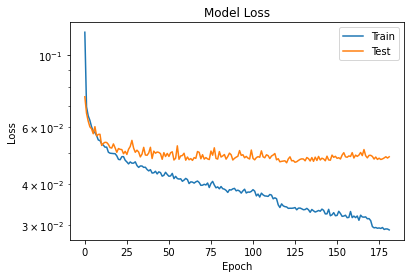

In [6]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('../NN42LossCurve.png')
plt.show()

In [7]:
pd.DataFrame(np.round(model.predict(x_test)) - y_test).abs().reset_index(drop=True).sum(axis=1).sort_values().index[100]

558

In [8]:
gridpoints = []
for z in np.linspace(-2,2,11):
  for y in np.linspace(-2,2,11):
    for x in np.linspace(-2,2,11):
      gridpoints.append((x,y,z))


In [9]:
import plotly.graph_objects as go
import numpy as np


prob_pred = model.predict(x_val)[2]
pred = np.round(prob_pred)

print(pred.shape)


fig = go.Figure(data=[
    go.Mesh3d(
        # 8 vertices of a cube
        x=np.array([[gridpoints[q][0]-0.2 for p in range(2)] + [gridpoints[q][0]+0.2 for p in range(2)] for p in range(2)]).flatten(),
        y=np.array([[gridpoints[q][1]-0.2] + [gridpoints[q][1]+0.2 for p in range(2)] + [gridpoints[q][1]-0.2] for p in range(2)]).flatten(),
        z=[gridpoints[q][2]-0.2 for p in range(4)] + [gridpoints[q][2]+0.2 for p in range(4)],
        i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
        j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
        k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
        color = 'green'
    )
 for q in range(1331) if (pred[q]==1)]
)


fig.show()


(1331,)


In [10]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(np.round(model.predict(x_val)).flatten(), np.array(y_val).flatten()))
print(recall_score(np.round(model.predict(x_val)).flatten(), np.array(y_val).flatten()))

0.8504363306018701
0.860312273731504


In [19]:
from plotly.subplots import make_subplots

def comparisonPlot(obj):

  prob_pred = model.predict(x_test)[obj]
  pred = np.round(prob_pred)
  print(prob_pred.mean())

  fig = make_subplots(
      rows=1, cols=2,
      specs=[[{'type': 'surface'}, {'type': 'surface'}]])

  for q in range(11**3):
    # adding surfaces to subplots.
  
    fig.add_trace(go.Mesh3d(
        # 8 vertices of a cube
        x=np.array([[gridpoints[q][0]-0.2 for p in range(2)] + [gridpoints[q][0]+0.2 for p in range(2)] for p in range(2)]).flatten(),
        y=np.array([[gridpoints[q][1]-0.2] + [gridpoints[q][1]+0.2 for p in range(2)] + [gridpoints[q][1]-0.2] for p in range(2)]).flatten(),
        z=[gridpoints[q][2]-0.2 for p in range(4)] + [gridpoints[q][2]+0.2 for p in range(4)],
        i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
        j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
        k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
        color = 'green',
        opacity = pred[q],
        ),
        row = 1, col = 1,
    )

    
    fig.add_trace(go.Mesh3d(
          # 8 vertices of a cube
          x=np.array([[gridpoints[q][0]-0.2 for p in range(2)] + [gridpoints[q][0]+0.2 for p in range(2)] for p in range(2)]).flatten(),
          y=np.array([[gridpoints[q][1]-0.2] + [gridpoints[q][1]+0.2 for p in range(2)] + [gridpoints[q][1]-0.2] for p in range(2)]).flatten(),
          z=[gridpoints[q][2]-0.2 for p in range(4)] + [gridpoints[q][2]+0.2 for p in range(4)],
          i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
          j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
          k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
          color = 'red',
          opacity = y_test.iloc[obj][q]*1
          ),
          row = 1, col = 2,
      )


  fig.update_layout(
      title_text='Accuracy = {0:.2%}'.format(model.evaluate(np.array([x_test[obj]]), np.array([y_test.iloc[obj]]))[1]),
  )
  fig.show()

comparisonPlot(1271)

0.08805496
1/1 [==============================] - 0s 260ms/step


In [21]:
comparisonPlot(912)

0.066258274
1/1 [==============================] - 0s 2ms/step


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
print(accuracy_score(np.round((model.predict(x_train)*1)).flatten(), np.array(y_train*1).flatten()))
print(precision_score(np.round((model.predict(x_train)*1)).flatten(), np.array(y_train*1).flatten()))
print(recall_score(np.round((model.predict(x_train)*1)).flatten(), np.array(y_train*1).flatten()))

0.9730311511073122
0.7566092236348274
0.8214665159046786


In [33]:
print(accuracy_score(np.round((model.predict(x_val)*1)).flatten(), np.array(y_val*1).flatten()))
print(precision_score(np.round((model.predict(x_val)*1)).flatten(), np.array(y_val*1).flatten()))
print(recall_score(np.round((model.predict(x_val)*1)).flatten(), np.array(y_val*1).flatten()))

0.9737900890723414
0.7652348660726576
0.8254117507324412


In [35]:
print(accuracy_score(np.round((model.predict(x_test)*1)).flatten(), np.array(y_test*1).flatten()))
print(precision_score(np.round((model.predict(x_test)*1)).flatten(), np.array(y_test*1).flatten()))
print(recall_score(np.round((model.predict(x_test)*1)).flatten(), np.array(y_test*1).flatten()))

0.973187824455509
0.7542186684535737
0.823898308663612


Now going to investigate effect of datasize on precision, recall and accuracy so we can extrapolate for a larger dataset size.

In [37]:
def definingDataSize(train_size, n_epochs=300,):

  x_train_red = pd.DataFrame(x_train).sample(train_size, random_state=42)
  y_train_red = y_train.iloc[x_train_red.index]

  early_stop = EarlyStopping(monitor='val_loss', patience=65, verbose=1, restore_best_weights=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, verbose=1,)

  model = Sequential()
  model.add(Dense(1000, input_dim=400, kernel_initializer='normal', activation='relu'))
  model.add(Dense(1331, kernel_initializer='normal', activation='sigmoid'))
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'], )
  model.summary()


  history = model.fit(x=x_train_red, y=y_train_red, validation_data = (x_val, y_val), epochs=n_epochs, verbose=1, callbacks = [early_stop, reduce_lr])
  
  pd.DataFrame(history.history).to_csv('../BatchSizeReduction2Ellipsoids/model_ts{}.csv'.format(train_size))

  model.save('../BatchSizeReduction2Ellipsoids/model_ts{}.h5'.format(train_size))

  return history

'''
for i in np.logspace(1,3,30, dtype=np.int64):
  definingDataSize(i)
'''

'\nfor i in np.logspace(1,3,30, dtype=np.int64):\n  definingDataSize(i)\n'

In [39]:
from keras.models import load_model
import numpy as np
import pandas as pd

losses = []

for train_size in np.logspace(1,3,30, dtype=np.int64):
  history = pd.read_csv('../BatchSizeReduction2Ellipsoids/model_ts{}.csv'.format(train_size))
  losses.append(history)
losses = [loss.drop(loss.columns[0], axis=1) for loss in losses]


In [40]:

from keras.models import load_model

test_accuracy = []
test_precision = []
test_recall = []
y_exact = np.array(y_test).flatten()

for train_size in np.logspace(1,3,30, dtype=np.int64):
  print(train_size)
  model = load_model('../BatchSizeReduction2Ellipsoids/model_ts{}.h5'.format(train_size))
  y_pred = np.round(model.predict(x_test)).flatten()

  accuracy = accuracy_score(y_pred, y_exact)
  precision = precision_score(y_pred, y_exact)
  recall = recall_score(y_pred, y_exact)
  test_accuracy.append(accuracy)
  test_precision.append(precision)
  test_recall.append(recall)


10
11
13
16
18
22
25
30
35
41
48
57
67
78
92
108
126
148
174
204
239
280
329
385
452
529
621
727
853
1000


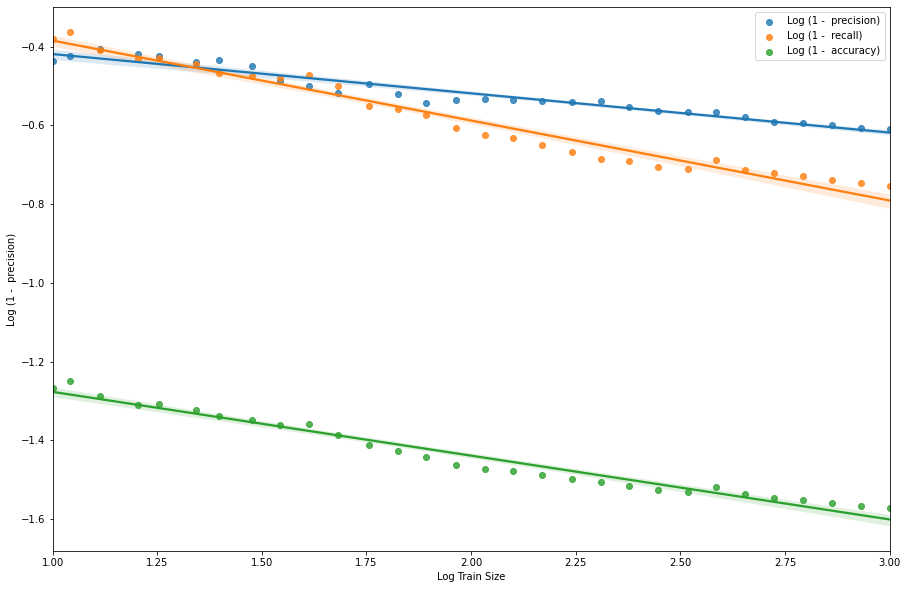

In [44]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x = np.log10(np.logspace(1,3,30, dtype=np.int64)), y = np.log10([1 - i for i in test_precision]), order=1, ax=ax, label = 'Log (1 -  precision)')
sns.regplot(x = np.log10(np.logspace(1,3,30, dtype=np.int64)), y = np.log10([1 - i for i in test_recall]), order=1, ax=ax, label = 'Log (1 -  recall)')
sns.regplot(x = np.log10(np.logspace(1,3,30, dtype=np.int64)), y = np.log10([1 - i for i in test_accuracy]), order=1, ax=ax, label = 'Log (1 -  accuracy)')
ax.set(xlabel='Log Train Size', ylabel='Log (1 -  precision)')
plt.legend()
plt.savefig('../BatchSizeReduction2Ellipsoids/TrainSizeVsValErr.png')
plt.show()

In [48]:
x = np.log10(np.logspace(1,3,30, dtype=np.int64))
y_accuracy = np.log10([1 - i for i in test_accuracy])
y_precision = np.log10([1 - i for i in test_precision])
y_recall = np.log10([1 - i for i in test_recall])


m_accuracy, b_accuracy = np.polyfit(x, y_accuracy, 1)
m_precision, b_precision = np.polyfit(x, y_precision, 1)
m_recall, b_recall = np.polyfit(x, y_recall, 1)


print(1 - 10**(m_accuracy*np.log10(5000)+b_accuracy))
print(1 - 10**(m_precision*np.log10(5000)+b_precision))
print(1 - 10**(m_recall*np.log10(5000)+b_recall))

0.9806855847560232
0.7947519700698185
0.8832092239815138


In [49]:
from sklearn.metrics import r2_score

print(r2_score(m_accuracy*x+b_accuracy, y_accuracy))
print(r2_score(m_precision*x+b_precision, y_precision))
print(r2_score(m_recall*x+b_recall, y_recall))


0.9691741143325737
0.9351374668973931
0.9672431929925834


In [50]:
print(x_train.shape)

(2891, 400)
